# <span style="color:green"> Environmental Sound Classification </span>
## <span style="color:green">Notebook 3: Classification via Convolutional Neural Networks </span>

---
[Mattia Pujatti](mattia.pujatti.1@studenti.unipd.it), ID 1232236, master degree in Physics of Data

---

This notebook has been realized as final project for the course of Human Data Analytics, held by professors [Michele Rossi](rossi@dei.unipd.it) and [Francesca Meneghello](meneghello@dei.unipd.it), during the academic year 2019/2020 at the University of Padua.

### Table of Content

1. #### [Introduction](#Introduction-to-Notebook-2) 
2. #### [Input Pipeline with TFRecords](#TFRecords)
3. #### [Classification with CNN models](#Convolutional-Neural-Networks)
    * #### [Effects of data augmentation](#with-data-augmentation)

## Project Presentation

*The main purpose of this notebook will be to provide an efficient way, using machine learning techniques, to classify environmental sound clips belonging to one of the only public available dataset on the internet. <br>
Several approaches have been tested during the years, but only a few of them were able to reproduce or even overcome the human classification accuracy, that was estimated around 81.30%. <br>
The analysis will be organized in the following way: since the very first approaches were maily focused on the examination of audio features that one could extract from raw audio files, we will provide a way to collect and organize all those "vector of features" and use them to distinguish among different classes. Then, different classification architectures and techniques will be implemented and compared among each other, in order also to show how they react to different data manipulation (overfitting, numerical stability,...). <br>
In the end, it will be shown that all those feature classifiers, without exceptions, underperform when compared to the results provided by the use of Convolutional Neural Networks directly on audio signals and relative spectrograms (so without any kind of feature extraction), and how this new approach opened for a large number of opportunities in term of models with high accuracy in sound classification.*

### Summary of Notebook 1 and 2

## Introduction to Notebook 3

In this third and last notebook we will examine the possibility of applying Convolutional Neural Networks to the task of environmental sound classification, through the conversion of all the sound clips provided in the ESC-50 dataset into time signals and/or spectrograms. <br>
We will first go trough a particular way of handling data, as _TFRecord_ files, and we will construct an input pipeline for our images via tensorflow, in order to provide a training and validation procedure that is as customizable as possible to deal with all our necessities. Then, we will check the performances of several CNN, which structure was inspired by many previous works by other data scientists and reported in the table [here](https://github.com/karolpiczak/ESC-50), and we will compare them again exploiting cross-validation. Moreover, we will examine also the augmented dataset realized in the first notebook, verifying also that augmenting directly the audio clips bring to better results than applying traditional image augmentation techniques on the corresponding spectrograms. <br>
In the end...

In [1]:
# Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import seaborn as sns
%matplotlib inline

import zipfile
import time
import datetime
from glob import glob
import os
from sys import stdout
from PIL import Image
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
sns.set_theme()

In order to simplify the drafting of this third notebook, all the previous useful functions and classes defined in the previous notebooks have been collected into two _.py_ files, that can be imported, and used, as libraries.

In [2]:
# Import all the functionalities provided in the first notebook
import Notebook1 as nb1
from importlib import reload  
reload(nb1)

<module 'Notebook1' from '/home/mattia/Desktop/PhysicsofData/Human Data Analytics/Environmental-Sound-Classification/Notebook1.py'>

## TFRecords

As anticipated before, handling the whole dataset of images can become computationally a problem, especially in the augmented case, for both the memory of the notebook and the performances of the tensorflow input pipeline that we are going to construct. For this reason, using a binary file format for the storage of our data can bring to a significant improvement in term of performances, and consequently also on the training time of our model. Binary data, in fact, takes up less space on disk, especially when compressed, and can be read in a much more efficient way. In our help, _tensorflow_ has developed its own binary storage format, that is the [_TFRecord_](https://medium.com/mostly-ai/tensorflow-records-what-they-are-and-how-to-use-them-c46bc4bbb564) format, gifted of a lot of preprocessing functionalities and the possibility of loading from the disk and processing only the data required at that particular time, allowing for an efficient way to deal with large datasets.

For this reason, the first step of this notebook will be defining a set of functions allowing for the conversion of the image datasets constructed in the first notebook (together with the canonical feature extraction) into TFRecord files. 

In [3]:
# The following functions can be used to convert - value to a type compatible with tf.train.Example.

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [4]:
def Generate_TFRecord_file(dataset, plot, out_name='data'):
    """Given a dataset of 'Clips' objects, this function construct a TFRecord file converting all
    the plots (time signals, spectrograms, melspectrograms) that one can generate from each clip."""
    
    if plot not in ['time_signals', 'spectrograms', 'melspectrograms']:
        print('Invalid value in the choice of the plot to generate.')
        return
    
    # Initialize a TFRecord file
    outputfile = os.getcwd() + '/' + out_name + '_' + plot + '.tfrecords'
    with tf.io.TFRecordWriter(outputfile) as tf_writer:
        
        # Loop over the clips
        with tqdm(total=len(dataset), desc='Looping over the dataset:', unit='clips', leave=False) as pbar:
            for _, row in dataset.iterrows():
                # Generate and reformat the desired plot
                fig, ax = plt.subplots(1,1,figsize=(6,3), dpi=100)
                if   plot == 'time_signals'   : row['clip'].DisplayWave(ax=ax)
                elif plot == 'spectrograms'   : row['clip'].DisplaySpectrogram(ax=ax, cbar=False)
                elif plot == 'melspectrograms': row['clip'].DisplayMelSpectrogram(ax=ax, cbar=False)
                ax.set_title('')
                ax.set_axis_off()

                canvas = FigureCanvas(fig)
                fig.tight_layout(pad=0)
                fig.canvas.draw()

                width, height = map(int, fig.get_size_inches() * fig.get_dpi())
                image = np.fromstring(canvas.tostring_argb(), dtype='uint8').reshape(height, width, 4)
                image = np.roll(a=image, shift=-1, axis=2)
                fig.clear()
                plt.close()
                
                # Construct the vector of features
                sample = row['clip']
                sample.Compute_Features('all')
                feat_vec = nb1.Construct_Vector_Features(sample, stat=['mean', 'std'], silence_elimination=0.5) 

                # Create a dictionary with the features with the proper types
                features = {'label'    : _int64_feature(row['clip'].target), 
                            'features' : _float_feature(feat_vec),
                            'image'    : _bytes_feature(image.tostring())}
            
                # Create an example protocol buffer
                tf_example = tf.train.Example(features=tf.train.Features(feature=features))
                # Write the example into the TFRecords file
                tf_writer.write(tf_example.SerializeToString())
                pbar.update(1)

Since, as repeated several times during the second notebook, the main problem of the ESC-50 dataset is the limited number of clips available, in order to construct a reliable statistics for the final accuracy of our data we decided to apply cross-validation. To simplify the approach for TFRecords, we decide to create the (stratified) K-Folds directly here, generating _k_ binary files that will be recombined into a training and validation sets in a subsequent loop.

In [5]:
def TFRecord_StratifiedKFold(dataset, plot, n_folds=5, dir_name='CV_tfrecords', out_name='data'):
    """In case a KFold splitting is needed, this function generate several TFRecord files to be used
    in a cross validation loop."""
    
    nb1.initialize_folder(dir_name)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
    
    for i, (_, fold_idx) in tqdm(enumerate(skf.split(dataset['clip'], dataset['label'])), total=n_folds, desc='Creating folds', unit='folds'):
        Generate_TFRecord_file(dataset.loc[fold_idx], plot, out_name=dir_name + '/' + out_name + '_fold_' + str(i)) 

In [6]:
esc50_dir = os.getcwd() + '/ESC-50-master/ESC-50-master/audio/'
#audio_data = nb1.Collect_Clips(esc50_dir, nb1.get_label_map(), nb1.macro_categories_map, leave_tqdm=False)

#TFRecord_StratifiedKFold(audio_data, plot='time_signals', n_folds=5, dir_name='timesig_CV_tfrecords')
#TFRecord_StratifiedKFold(audio_data, plot='spectrograms', n_folds=5, dir_name='CV_tfrecords')
#TFRecord_StratifiedKFold(audio_data, plot='melspectrograms', n_folds=5, dir_name='melspec_CV_tfrecords')

For the augmented dataset, instead, for which a cross-validation is not needed, we have to define a function that allow us to split all the augmented clips into a train and a test set, in a reasonable way. With reasonable way we intend that we should put in the same dataset a fraction of clips together with all its augmented versions, since mixing them would imply overfitting the data.

In [7]:
def TrainTest_Split_AugmentedData(augmented_folder, plot, out_name, test_frac=0.2):
    
    # Folder with the original untouched data
    original_folder = augmented_folder + 'original/'
    audio_data = nb1.Collect_Clips(original_folder, nb1.get_label_map(), nb1.macro_categories_map, leave_tqdm=False)
    
    train, _ = train_test_split(audio_data, test_size=test_frac)
    train_clipnames = train['clip'].apply(lambda x: x.clipname).to_numpy()
    
    # Now collect all the augmented clips
    augmented_data = nb1.get_augmented_data(augmented_folder)
    
    # Distinguish among train and test clips
    augmented_data['class'] = augmented_data['clip'].apply(lambda x: 'train' if x.clipname in train_clipnames else 'test')

    Generate_TFRecord_file(augmented_data[augmented_data['class']=='train'], plot, out_name=out_name + '_train')
    Generate_TFRecord_file(augmented_data[augmented_data['class']=='test'],  plot, out_name=out_name + '_test')

#TrainTest_Split_AugmentedData(os.getcwd( + '/augmented_clips/', plot='spectrograms', out_name='augmented_data')

## Convolutional Neural Networks

Now, that we have collected and organized all our data into _TFRecord_ files, is time to select the machine learning classifier that we will use to distinguish different sound categories based only on their spectrograms. <br>
Our choice fell on _Convolutional Neural Networks_: several papers have proven so far that the usage of CNN for spectrogram classification brings excellent results, in a way that, all the high accuracies obtained on the ESC-50 dataset and summarized [here](https://github.com/karolpiczak/ESC-50), have all been achieved thank to those architectures. So, apparently, the possibility of learning local structures from a bidimensional input outperforms our previous approaches, mainly based on the extraction of vectors of features, directly from the raw audio files. <br> 
So, even if we have reached very good results in term of classification accuracy exploiting data augmentation, below we will effectively notice that there are even better approaches, that allow us to derive better performances, directly on the non-augmented data, at the expenses of some velocity and datasets more difficult to handle.

Following the same strategy used also in the previous notebooks, we will define a whole class to handle all the necessary functions to study and fit such spectrogram datasets. 

This is the internal structure of the class `ImageClipsClassifier`:

* `__init__`: constructor of the class, takes in input a machine learning model and allow to fix some training
    and setup parameters.
* `_Read_TFRecord`: read and decode, according to a predefined format, a sample of the TFRecord file.
* `_Augment_Dataset`: function that map to the input tf.data.Dataset five image augmentation steps.
* `_Preprocess_Dataset`: given the path of one (or more) TFrecord files, this function load their content into a dataset, creating an input pipeline of tensors that also apply some preprocessing and optional augmentation steps.
* `__train_step` and `__test_step`: functions to handle a customizable training loop for our model.
* `_Train_and_Evaluate`: given two batched datasets, this function run a training loop storing, for each epoch, the loss and the accuracy for both the train and validation sets.
* `Run_Cross_Validation` and `Run_Cross_Validation_from_images`:  with several calls to `_Train_and_Evaluate` it is possible to implement a cross validation, particularly useful when the dataset is small; two functions are defined for the situations in which you have a folder of TFRecord files or directly the images.
* `TrainTest_Model`: when the dataset is large enough no cross validation is needed, and so it is just convenient to split it into a training and validation sets. 

In [15]:
class ImageClipsClassifier():
    """The main purpose of this class is to collect all the necessary steps and functions to construct and
    train a CNN to our image datasets."""
    
    
    def __init__(self, model, n_classes=50, epochs=15, img_shape=(300, 600, 4), batch_size=16, verbose=1):
        """Initialize some global parameters, together with loss and accuracy functions."""
        
        self.model = model
        self.n_classes = n_classes
        self.epochs = epochs
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.verbose = verbose

        self.history = pd.DataFrame(index=np.arange(self.epochs), columns=['train_loss', 'val_loss','train_metric', 'val_metric'])

        # Instantiate an optimizer.
        self.optimizer = tf.keras.optimizers.Adamax(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
        # Instantiate a loss function.
        self.loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

        # Prepare the metrics.
        self.train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        self.val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        

    def _Read_TFRecord(self, example):
        """Parse the input tf.train.Example proto using a proper dictionary."""
    
        # Create a dictionary describing the features.
        tfrecord_format = { 'image'    : tf.io.FixedLenFeature([], tf.string),
                            'features' : tf.io.FixedLenFeature([110], tf.float32),
                            'label'    : tf.io.FixedLenFeature([], tf.int64) }
    
        example = tf.io.parse_single_example(example, tfrecord_format)
    
        # Actually, we are interested only in the image and the label
        # Decode the image
        image = tf.io.decode_raw(example['image'], out_type=tf.uint8)
        image = tf.reshape(image, shape=self.img_shape)

        # Read the label
        label = tf.cast(tf.one_hot(example['label'], depth=self.n_classes), tf.uint8)
    
        return image, label
    
    def _Augment_Dataset(self, ds):
        """Given a dataset of (image, label) pairs, it generates several new datasets
        according to some image augmentation techniques, concatenating them to the original
        object. In particular, the augmentation will be focused on:
        * brightness
        * contrast
        * noise addition
        * left-right flip."""
        
        ds = ds.repeat(5)
        # Adjust the brightness
        ds = ds.map(lambda image, label: (tf.image.random_brightness(image, 0.1), label))
        # Adjust the contrast
        ds = ds.map(lambda image, label: (tf.image.random_contrast(image, 0.8, 1.2), label))
        # Add random uniform noise
        uniform_noise = tf.random.uniform(shape=self.img_shape, minval=0, maxval=1, dtype=tf.int64)
        ds = ds.map(lambda image, label: (image + tf.cast(uniform_noise,dtype=tf.uint8), label))
        # Left right flip
        ds = ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))

        return ds
    
    
    def _Preprocess_Dataset(self, files, augmentation=False, reshuffle=False):
        """Given the path of a TFRecord file, the function read the file and apply some
        preprocessing steps over the data stored. In particular:
        * cache 
        * augmentation (optional)
        * shuffle (+ optional reshuffle_each_iteration)
        * image normalization
        * batch
        * prefetch
        """
        
        # Load the dataset
        ds = tf.data.TFRecordDataset(files, num_parallel_reads=tf.data.AUTOTUNE)
        ds.cache()
        
        # Read and convert the data stored
        ds = ds.map(self._Read_TFRecord)

        # Augment data (optional)
        if augmentation: ds = self._Augment_Dataset(ds)
    
        # Shuffle the dataset
        full_len = ds.reduce(np.int64(0), lambda x, _: x + 1).numpy()
        ds = ds.shuffle(full_len, reshuffle_each_iteration=reshuffle)
        # If the order is ininfluent, this will speed up the computation
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
        # Rescale the images in [-1,1]
        ds = ds.map(lambda image, label: ((1/255.)*tf.cast(image, tf.float32)*2.0-1.0, label))
    
        # Batch and prefetch
        ds = ds.batch(self.batch_size, drop_remainder=True)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    
        return ds
        
        
    @tf.function
    def __train_step(self, x, y): 
        with tf.GradientTape() as tape:
            # Forward Pass.
            logits = self.model(x, training=True)
            # Compute the loss for the minibatch.
            loss_value = self.loss_fn(y, logits)
        # Use the gradient tape to automatically retrieve the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        # Run one step of gradient descent.
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        # Update training metric.
        self.train_acc_metric.update_state(y, logits)
        return loss_value
    
    
    @tf.function
    def __test_step(self, x, y):
        val_logits = self.model(x, training=False)
        # Compute the loss for the minibatch.
        loss_value = self.loss_fn(y, val_logits)
        # Update val metrics
        self.val_acc_metric.update_state(y, val_logits)   
        return loss_value

    
    def _Train_and_Evaluate(self, training_set, validation_set, lengths):
        """Given two batched tensorflow datasets, this function will train the model over the batches of 
        the training set, then evaluating it over the validation set, computing the proper loss and accuracy
        fullfilling an history dataframe, containing such value for each epoch."""
        
        with tqdm(total=self.epochs, desc='Training epochs:', unit='epochs', leave=False) as epochs_pbar:
            for epoch in range(self.epochs):
            
                train_batch_errors = []
                val_batch_errors = []

                # Iterate over the batches of the dataset.
                with tqdm(total=lengths['train'], desc='Training over the minibatches:', unit='batches', leave=False) as train_pbar:
                    for step, (x_batch_train, y_batch_train) in enumerate(training_set):
                        # Manually detect the end of the loop (if training_set is an iterator)
                        if step >= lengths['train']: 
                            train_pbar.close()
                            break
                        # Run training step
                        loss_train_value = self.__train_step(x_batch_train, y_batch_train)
                        train_pbar.update(1)
                        train_batch_errors.append(loss_train_value)
                
                # Display metrics at the end of each epoch.
                train_loss = sum(train_batch_errors)
                train_acc = self.train_acc_metric.result()

                # Reset training metrics at the end of each epoch
                self.train_acc_metric.reset_states()

                # Run a validation loop at the end of each epoch.
                with tqdm(total=lengths['val'], desc='Evaluating over the validation set:', unit='batches', leave=False) as val_bar:
                    for step, (x_batch_val, y_batch_val) in enumerate(validation_set):
                        # Manually detect the end of the loop (if validation_set is an iterator)
                        if step >= lengths['val']: 
                            val_bar.close()
                            break
                        loss_val_value = self.__test_step(x_batch_val, y_batch_val)
                        val_bar.update(1)
                        val_batch_errors.append(loss_val_value)
                
                val_loss = sum(val_batch_errors)
                val_acc = self.val_acc_metric.result()
                self.val_acc_metric.reset_states()

                self.history.loc[epoch] = [train_loss.numpy()/lengths['train'], val_loss.numpy()/lengths['val'], train_acc.numpy(), val_acc.numpy()]
                epochs_pbar.update(1)
                if self.verbose >= 1:
                    stdout.write('\rTraining Loss: {:.3f}   Validation Loss: {:.3f}     Training Accuracy:  {:.3f}   Validation Accuracy:   {:.3f}\n'.format(
                        train_loss.numpy()/lengths['train'], val_loss.numpy()/lengths['val'], train_acc.numpy(), val_acc.numpy()))
                    stdout.flush()
                
    
    
    def Run_Cross_Validation(self, path):
        """Given a path with n TFRecord files representing the folds of our dataset, we run a cross validation
        algorithm over such folds."""
        
        # Loop over the TFRecords in the folder, keeping just one of them as validation set, and load
        # the remaining one as training sets
        tfrecords = glob(path + '*.tfrecords')
        
        # Save initial setup to reset the weights later
        self.model.save_weights('dummy_model.h5')
        
        cross_results = pd.DataFrame(0, index=np.arange(self.epochs*len(tfrecords)), columns=['fold', 'train_metric', 'val_metric'])
        
        for fold, val_file in tqdm(enumerate(tfrecords), desc='Running Cross Validation:', total=len(tfrecords), unit='folds'):

            train_ds = self._Preprocess_Dataset([x for x in tfrecords if x != val_file], augmentation=False, reshuffle=True)
            val_ds = self._Preprocess_Dataset(val_file, augmentation=False, reshuffle=True)

            lengths = {'train' : train_ds.reduce(np.int64(0), lambda x, _: x + 1).numpy(),
                       'val'   :   val_ds.reduce(np.int64(0), lambda x, _: x + 1).numpy()}
            
            self._Train_and_Evaluate(train_ds, val_ds, lengths)

            cross_results.loc[fold*self.epochs:(fold+1)*self.epochs-1, 'fold'] = [fold+1]*self.epochs
            cross_results.loc[fold*self.epochs:(fold+1)*self.epochs-1, ['train_loss', 'val_loss', 'train_metric', 'val_metric']] = self.history.values

            # Reset the weigths of the model at each iteration of the cross validation
            if fold < (len(tfrecords)-1): self.model.load_weights('dummy_model.h5')
            
        # Remove the dummy file created
        os.remove('dummy_model.h5')

        return cross_results


    def TrainTest_Model(self, tfrecord, val_set=None, test_frac=0.2, augment=False):
        """Given a TFRecord file, the function load and preprocess the datased inside it, and it splits into a training and a test sets.
        Then, it runs the training + evaluation procedure over the datasets obtained."""
        
        # Allow for a manual train test splitting
        if val_set is None:
            # Disable reshuffle to allow a train-test split
            full_dataset = self._Preprocess_Dataset(tfrecord, augmentation=augment, reshuffle=False)
            full_len = full_dataset.reduce(np.int64(0), lambda x, _: x + 1).numpy()
            train_size = int(full_len*(1-test_frac))
            
            train_ds = full_dataset.take(train_size)
            val_ds = full_dataset.skip(train_size)
            
        else:
            train_ds = self._Preprocess_Dataset(tfrecord, augmentation=augment, reshuffle=False)
            val_ds = self._Preprocess_Dataset(val_set, augmentation=augment, reshuffle=False)

        lengths = {'train' : train_ds.reduce(np.int64(0), lambda x, _: x + 1).numpy(),
                   'val'   :   val_ds.reduce(np.int64(0), lambda x, _: x + 1).numpy()}
        
        # Now enable reshuffle_each_iteration
        train_ds = train_ds.shuffle(lengths['train'], reshuffle_each_iteration=True)
        val_ds   = val_ds.shuffle  (lengths['val'],   reshuffle_each_iteration=True)
        
        self._Train_and_Evaluate(train_ds, val_ds, lengths)

        return self.history
                
                
  
    def Run_Cross_Validation_from_images(self, path, n_folds=5):
        """In case you have a set of folders with the images, instead of the TFRecord files, you can
        load those images as tensors as well, and then run a cross validation over them."""
        
        # Read data folder
        dataset = pd.DataFrame()
        dataset['filename'] = glob(path + '*/*.png')
        dataset['class'] = dataset['filename'].str.split('/').str[-2]
        
        # Instantiate an object ImageDataGenerator, for scaling the images in [-1,1]
        imgdatagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, preprocessing_function=lambda img: img*2.0-255.)

        # Create the folds grouping some minibatches
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42).split(dataset['filename'], dataset['class'])

        # Save initial setup to reset the weights later
        self.model.save_weights('dummy_model.h5')

        cross_results = pd.DataFrame(0, index=np.arange(self.epochs*n_folds), columns=['fold', 'train_metric', 'val_metric'])

        for fold, (train_index, test_index) in tqdm(enumerate(skf), desc='Running Cross Validation:', total=n_folds, unit='folds'):
            
            # Create an input pipeline for the tensors
            train_datagen = imgdatagen.flow_from_dataframe(dataframe = dataset.loc[train_index,:], target_size = self.img_shape[0:2], 
                                                     color_mode = 'rgba', class_mode = 'categorical', batch_size = self.batch_size, shuffle = True)
      
            test_datagen = imgdatagen.flow_from_dataframe(dataframe = dataset.loc[test_index,:], target_size = self.img_shape[0:2], 
                                                     color_mode = 'rgba', class_mode = 'categorical', batch_size = self.batch_size, shuffle = True)
        
            lengths = {'train' : len(train_datagen), 'val' : len(test_datagen)}
            self._Train_and_Evaluate(train_datagen, test_datagen, lengths)

            cross_results.loc[fold*self.epochs:(fold+1)*self.epochs-1, 'fold'] = [fold+1]*self.epochs
            cross_results.loc[fold*self.epochs:(fold+1)*self.epochs-1, ['train_loss', 'val_loss', 'train_metric', 'val_metric']] = self.history.values

            # Reset the weigths of the model at each iteration of the cross validation
            if fold < (len(tfrecords)-1): self.model.load_weights('dummy_model.h5')
            
        # Remove the dummy file created
        os.remove('dummy_model.h5')

        return cross_results  

Let's display some examples of the images we are going to analyze.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tarfile
tar = tarfile.open('/content/drive/MyDrive/machine_learning_data/CV_tfrecords.tar.xz', "r:xz")
tar.extractall()
tar.close()

(None,)


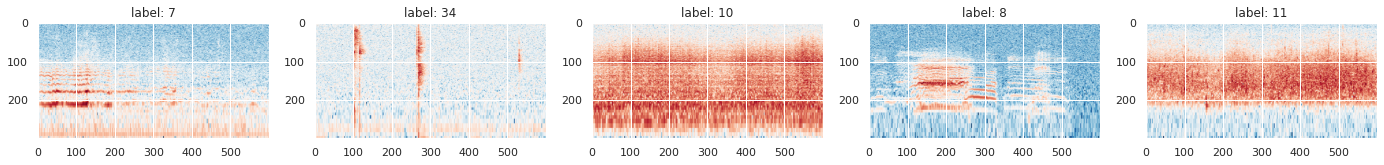

In [21]:
fig, ax = plt.subplots(1, 5, figsize=(24,5))

ds = ImageClipsClassifier(model=None)._Preprocess_Dataset(os.getcwd() + '/CV_noisy_spectrograms/fold1_spectrograms.tfrecords')

for batch in ds:
    for idx in range(5):
        # Labels are one-hot encoded
        ax[idx].set_title('label: {}'.format(np.argmax(batch[1][idx]), axis=1))
        # Images are normalized in [-1,1], so we need to convert them back to [0,1]
        ax[idx].imshow((batch[0][idx]+1)*0.5);
    break

Then, it is all about selecting a proper model to fit our data: as can be noticed looking directly to the constructor of the class, we have already made several choices dictated by the research of the best performances, leaving outside of the class the specific definition of the architecture. In particular:
* labels are one-hot encoded, particularly useful when working with neural networks since we can make the last layer to have exactly 50 neurons, one for each possible class of our spectrograms;
* CategoricalCrossentropy as loss function and CategoricalAccuracy as first metric, and the motivations are obvious, given the problem that we are analyzing;
* the optimizer is `Adamax`, that apparently outperforms `Adam` for almost any architecture studied, with a learning rate that is quite small, around 0.0005, that turned out to represent a good tradeoff between convergence speed and accuracy reached.

The architecture used is the following, in which we can distinguish 3 convolutional blocks, characterized by an increasing number of filters and a progressive reduction of the kernel size, in order to simplify the learning of features that will be smaller and smaller as they pass through the network. In fact, at the end of each block it has been placed a MaxPooling layer with the purpose of reducing the size of the input images: particularly relevant is the first pooling layer, which strides are set to (2,4), in such a way we can transform the images from a rectangular to a square shape. Then, there is a fourth fully-connected block that ends with a layer composed by exactly 50 neurons, that correspond to the 50 possible classes of our images. As activation function we selected the `PReLU` for all the layers, since it helps the network to prevent vanishing gradients and does not increase too much the time necessary to process the epochs. <br>
This architecture has been inspired by several Convolutional model and canonical structures that have been used for this kind of problems, and in particular to [AlexNet](https://www.jeremyjordan.me/convnet-architectures/) and [VGG16](https://neurohive.io/en/popular-networks/vgg16/), even if those ones were mainly designed for the dataset ImageNet.

In [42]:
def Initialize_CNN():
    CNN = Sequential([
        layers.InputLayer(input_shape=(300, 600, 4), name='input'),

        layers.Conv2D(filters=64, kernel_size=11, strides=4, padding='same', name='block1_conv1'),
        layers.PReLU(name='block1_act1'),
        layers.MaxPool2D(3, strides=(2,4), name='block1_pool'),

        layers.Conv2D(filters=128, kernel_size=5, padding='same', name='block2_conv1'),
        layers.PReLU(name='block2_act1'),
        layers.MaxPool2D(3, strides=2, name='block2_pool'),
    
        layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv1'),
        layers.PReLU(name='block3_act1'),
        layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv2'),
        layers.PReLU(name='block3_act2'),
        layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv3'),
        layers.PReLU(name='block3_act3'),
        layers.MaxPool2D(3, strides=2, name='block3_pool'),

        layers.Dropout(0.5, name='block4_dropout1'),
        layers.Flatten(name='block4_flatten'),
        layers.Dense(256, name='block4_fc1'),
        layers.PReLU(name='block4_act1'),
        layers.Dropout(0.5, name='block4_dropout2'),
        layers.Dense(256, name='block4_fc2'),
        layers.PReLU(name='block4_act2'),
        layers.Dropout(0.5, name='block4_dropout3'),
        layers.Dense(50, name='predictions'),
        ])
    return CNN

In [ ]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 75, 150, 64)       31040     
_________________________________________________________________
block1_act1 (PReLU)          (None, 75, 150, 64)       720000    
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       204928    
_________________________________________________________________
block2_act1 (PReLU)          (None, 37, 37, 128)       175232    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 18, 18, 256)       2

Let's start training our model over the dataset of _spectrograms_. As anticipated before, we will use a cross validation approach, to compensate at least partially the lack of data, with 5 folds, in a way that we will train the CNN over 1600 samples, and validate it over 400.

In [13]:
ICC_spectrograms = ImageClipsClassifier(Initialize_CNN(), batch_size=16, epochs=100, verbose=0)
spectrograms_cv_scores = ICC_spectrograms.Run_Cross_Validation(os.getcwd() + '/CV_tfrecords/')

Here, we report the trend of the accuracy and the loss for both sets as the training proceeds. We decided to to represent this behavior using boxplots for every epoch, to summarize the values of the accuracy/loss across different folds. The main purpose of this choice was the possibility of controlling the statistics of the results, in particular if the folds were created nicely and they did not behave too differently, one respect to the others.

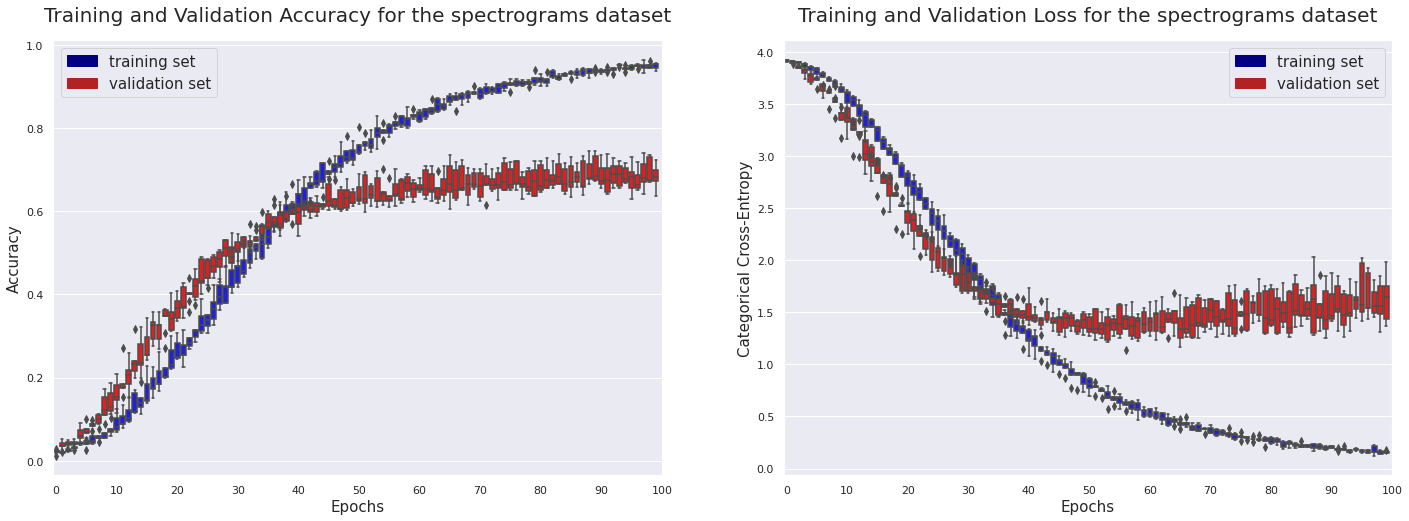

In [17]:
spectrograms_cv_analysis = spectrograms_cv_scores.copy()
spectrograms_cv_analysis['epoch'] = [i+1 for i in range(100)]*5

fig, ax = plt.subplots(1, 2, figsize=(24,8))

sns.boxplot(x='epoch', y='train_metric', data=spectrograms_cv_analysis.reset_index(), color='blue', ax=ax[0])
sns.boxplot(x='epoch', y='val_metric', data=spectrograms_cv_analysis.reset_index(), color='red', ax=ax[0])

ax[0].set_xticks([i for i in range(0, 101, 10)])
ax[0].set_xticklabels([i for i in range(0,101,10)])
ax[0].set_xlabel('Epochs', fontsize=15)
ax[0].set_ylabel('Accuracy', fontsize=15)
ax[0].set_title('Training and Validation Accuracy for the spectrograms dataset', fontsize=20, y=1.03)
ax[0].legend(handles=[mpatches.Patch(color='navy', label='training set'), mpatches.Patch(color='firebrick', label='validation set')], fontsize=15)

sns.boxplot(x='epoch', y='train_loss', data=spectrograms_cv_analysis.reset_index(), color='blue', ax=ax[1])
sns.boxplot(x='epoch', y='val_loss', data=spectrograms_cv_analysis.reset_index(), color='red', ax=ax[1])

ax[1].set_xticks([i for i in range(0, 101, 10)])
ax[1].set_xticklabels([i for i in range(0,101,10)])
ax[1].set_xlabel('Epochs', fontsize=15)
ax[1].set_ylabel('Categorical Cross-Entropy', fontsize=15)
ax[1].set_title('Training and Validation Loss for the spectrograms dataset', fontsize=20, y=1.03)
ax[1].legend(handles=[mpatches.Patch(color='navy', label='training set'), mpatches.Patch(color='firebrick', label='validation set')], fontsize=15);

In [18]:
ICC_spectrograms.model.save_weights('emergency_save.h5')

The error and accuracy behaviors clearly show that the convergence is soon reached after some epochs, since the validation error starts flunctuating and rising again already after 60 epochs, and so an early stopping condition could be reasonable. The model chosen obviously overfit the training sets: both the error and the accuracy converge to an optimal classification condition after the 100 epochs, in a stable way, in the sense that the boxes are smaller and smaller as the training proceeds. The overall validation accuracy, instead, converges to a value around the 70%, with a similar profile to the one encountered during feature classification (notebook 2). <br>
In the end, since the boxes in the plot are more or less quite regular, we can also be satisfied about the credibility of the statistics of the results and about the procedure we used to create the various folds.

### Analysis of filters and features maps

In neural network terminology, the learned filters are simply weights, yet because of the specialized two-dimensional structure of the filters, the weight values have a spatial relationship to each other and plotting each filter as a two-dimensional image is meaningful (or could be). <br>
We will examine the filters stored in the first convolutional layer, that are 11x11 filters, with 4 channels.



In [6]:
model = ImageClipsClassifier(model=Initialize_CNN()).model
model.load_weights('emergency_save.h5')

In [7]:
#model.get_weights()

In [8]:
# summarize filter shapes of convolutional layers
for layer in model.layers:
    if 'conv' not in layer.name: continue
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (11, 11, 4, 64)
block2_conv1 (5, 5, 64, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)


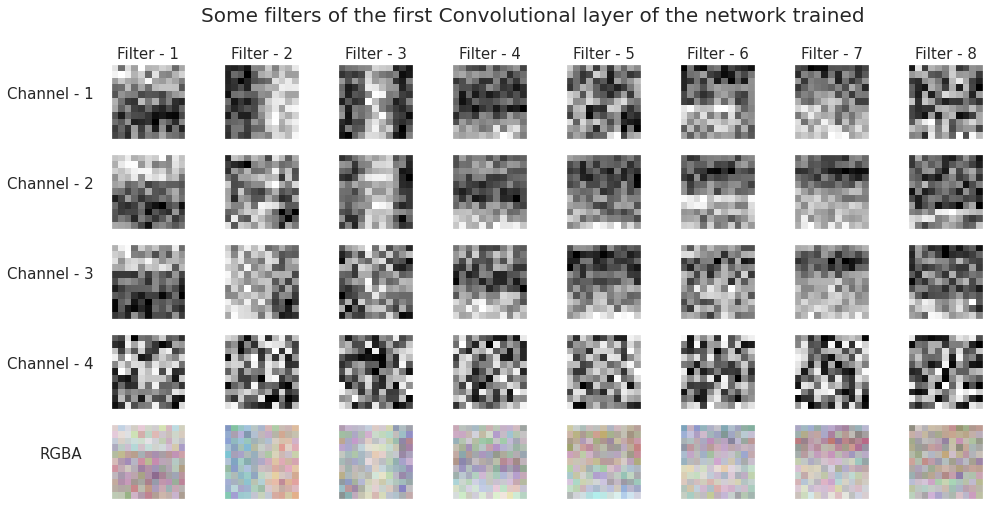

In [9]:
# Let's examine some of the the 64 filters of the first layer
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

fig, ax = plt.subplots(5, 8, figsize=(16,8))

for i in range(8):
    for j in range(4):
        ax[j][i].imshow(filters[:,:,j,i], cmap='gray')
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
        if i == 0: ax[j][i].set_ylabel('Channel - %i' % (j+1), rotation=0, labelpad=60, fontsize=15)
        if j == 0: ax[j][i].set_title('Filter - %i' % (i+1), fontsize=15)

for i in range(8):
    ax[4][i].imshow(filters[:,:,:,i])
    ax[4][i].set_xticks([])
    ax[4][i].set_yticks([])
ax[4][0].set_ylabel('RGBA', rotation=0, labelpad=50, fontsize=15)

  
fig.suptitle('Some filters of the first Convolutional layer of the network trained', fontsize=20);

The feature maps, instead, capture the result of applying the filters to input, such as the input image or another feature map. The idea of visualizing a feature map for a specific input image would be to understand what features of the input are detected or preserved in the feature maps. The expectation would be that the feature maps close to the input detect small or fine-grained detail, whereas feature maps close to the output of the model capture more general features. 

In [10]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 block1_conv1 (None, 75, 150, 64)
3 block2_conv1 (None, 37, 37, 128)
6 block3_conv1 (None, 18, 18, 256)
8 block3_conv2 (None, 18, 18, 256)
10 block3_conv3 (None, 18, 18, 256)


We can use this information and design a new model that is a subset of the layers in the full trained architecure. The model would have the same input layer as the original model, but the output would be the output of a given convolutional layer, which we know would be the activation of the layer or the feature map. Making a prediction with this new implementation, will give the feature map for the first convolutional layer for a given provided input image.

In [11]:
feat_model = Model(inputs=model.inputs, outputs=model.layers[0].output)

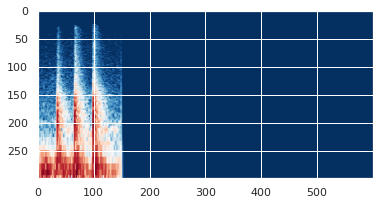

In [14]:
# Load a random sample spectrogram
for batch in ds:
    rnd_sample = batch[0][np.random.randint(16)]
    rnd_sample = (rnd_sample+1)*0.5
    plt.imshow(rnd_sample)
    
rnd_sample = np.expand_dims(rnd_sample.numpy(), axis=0)

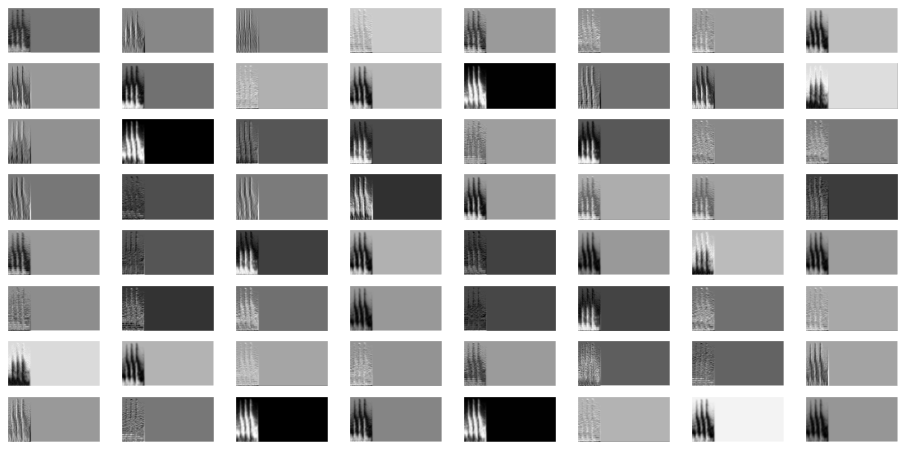

In [15]:
# Get the feature maps for first hidden layer
feature_maps = feat_model.predict(rnd_sample)

fig, axs = plt.subplots(8, 8, figsize=(16,8))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(feature_maps[0,:,:,i], cmap='gray')
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Let's do the same also for the other convolutional layers, keeping in mind that for them the feature maps will be squares. As we saw before, we have more than 64 maps for the successive convolutions but, to avoid having complex and unreadable plots, we will select only a few of them.

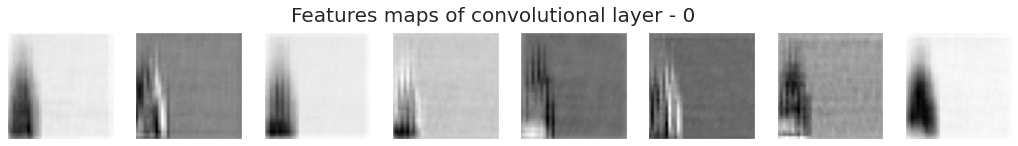

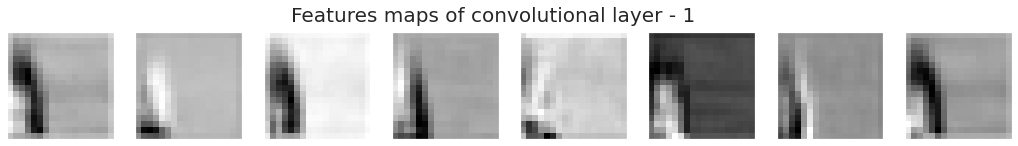

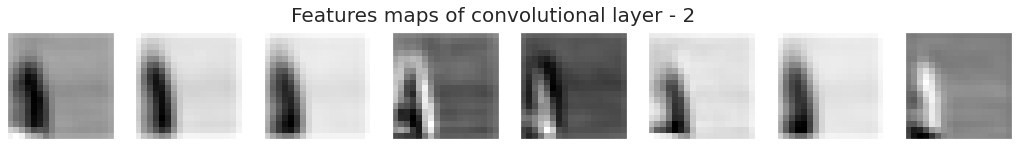

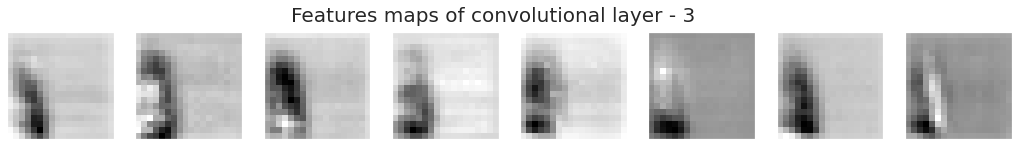

In [16]:
feat_models = Model(inputs=model.inputs, outputs=[model.layers[i].output for i in [3, 6, 8, 10]]) 
feature_maps = feat_models.predict(rnd_sample)

axs = axs.flatten()

for idx, fmap in enumerate(feature_maps):
    fig, ax = plt.subplots(1, 8, figsize=(18,2))
    fig.suptitle('Features maps of convolutional layer - %i' % idx, y=1.05, fontsize=20)
    for i in range(8):
        ax[i].imshow(fmap[0,:,:,i], cmap='gray')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

### Confusion matrices

Let's compare now the predictions over the ESC50 dataset, obtained from our 3 main classifiers:
* Human classification (given)
* Features classification (Notebook 2)
* CNN classification (this notebook)

and, in particular, let's focus on the differences between them, to effectively understand if the models are able to extract different kind of information from the clips, or a new, innovative, approach is needed to improve our final accuracy.

Remark: we already noticed, working with features in notebook 2, that if you are gonna use a neural network for a classification problem with such a large number of classes, there may be some of them that are never predicted by the final fitted model. And this can be due to the fact that the architecture remain "stucked" in configurations that do not guarantee a complete classification. Our suggestion to face this problem are: increasing the number of training epochs, avoid using too many layers and alway check the behavior of the confusion matrix.

Since our model has been trained using a cross-validation approach, we will take the confusion matrix based on the predictions obtained from the last training step, i.e. using the last fold as validation set. Obviously, in this way, the results will be a bit biased from the fold selected but, as seen before, showing the accuracies as boxplots versus the epochs, the various sets have been proved to be "enough balanced", and so the approach we will follow seems reasonable.

In [17]:
def Normalize_Confusion_Matrix(confusion_matrix):
    """Given a confusion matrix with the 'counts' as entries, such matrix will be renormalized in order
    to represent probabilities."""
    
    row_sums = confusion_matrix.sum(axis=1)
    return (confusion_matrix/row_sums[:, np.newaxis])

In [18]:
# Load/compute the 3 (normalized) confusion matrices
human_confmat = pd.read_csv(os.getcwd() + '/esc50_confusion_matrix.csv', header=None)
human_confmat = human_confmat.replace(to_replace='\xa0', value=0).astype(np.int32)
human_confmat = Normalize_Confusion_Matrix(human_confmat.to_numpy())

feat_confmat = np.loadtxt(os.getcwd() + '/ConfusionMatrix_feature_classification.txt')
feat_confmat = Normalize_Confusion_Matrix(feat_confmat)

# Load and preprocess the images and the labels of the last fold of the cross-validation (unseen in the last fit)
ESC50 = ImageClipsClassifier(model=None)._Preprocess_Dataset(os.getcwd() + '/CV_tfrecords/data_fold_0_spectrograms.tfrecords')
ESC50_spectrograms = ESC50.map(lambda image, label: image)
labels = list(ESC50.map(lambda image, label: tf.argmax(label, axis=1)).unbatch().as_numpy_iterator())
predictions = np.argmax(model.predict(ESC50_spectrograms), axis=1)

CNN_confmat = confusion_matrix(labels, predictions)
CNN_confmat = Normalize_Confusion_Matrix(CNN_confmat)

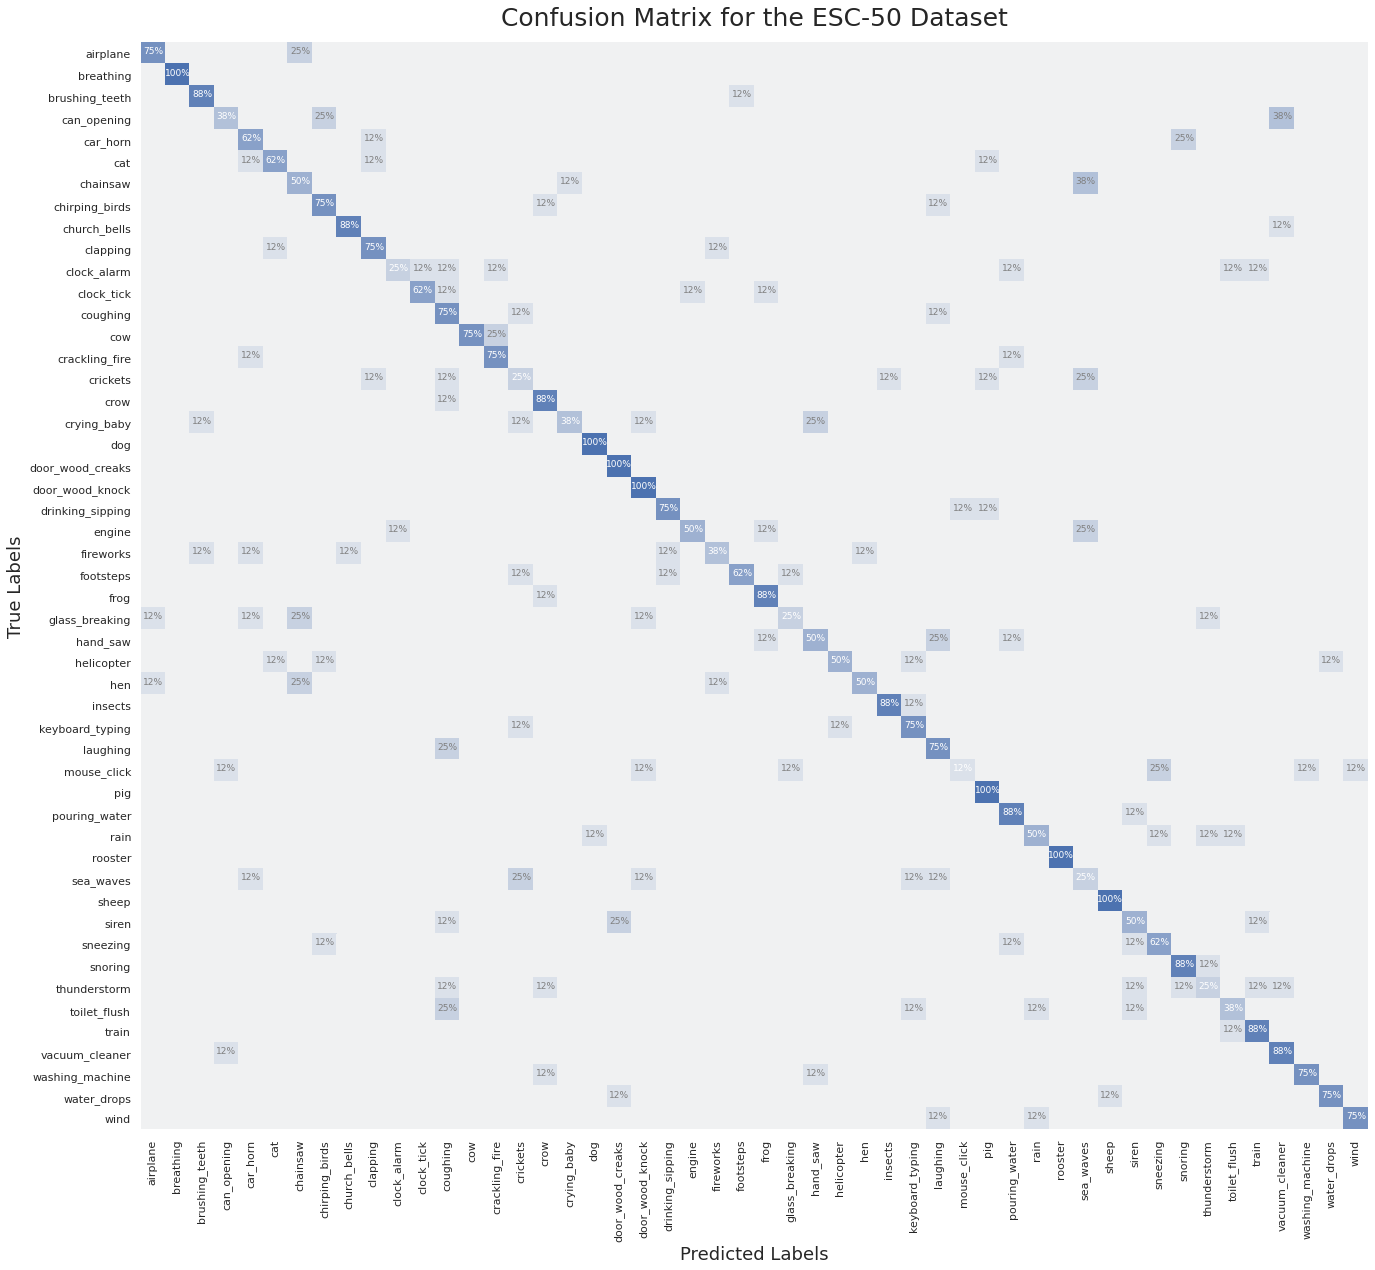

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(22,20))

sns.heatmap(CNN_confmat, cmap=sns.color_palette("light:b", as_cmap=True), ax=ax, cbar=False)
ax.set_title('Confusion Matrix for the ESC-50 Dataset', fontsize=25, y=1.01)
ax.set_xticklabels(np.unique(list(nb1.get_label_map().values())), rotation=90)
ax.set_yticklabels(np.unique(list(nb1.get_label_map().values())), rotation=0)
ax.set_xlabel('Predicted Labels', fontsize=18)
ax.set_ylabel('True Labels', fontsize=18)

for x in range(50):
    for y in range(50):
        if CNN_confmat[y, x] != 0:
            if x==y: c = 'white'
            else: c = 'grey'
            ax.text(x+0.5, y+0.5, "{:.0%}".format(CNN_confmat[y, x]), fontsize=9, ha='center', color=c)  

Small comment about the confusion matrix

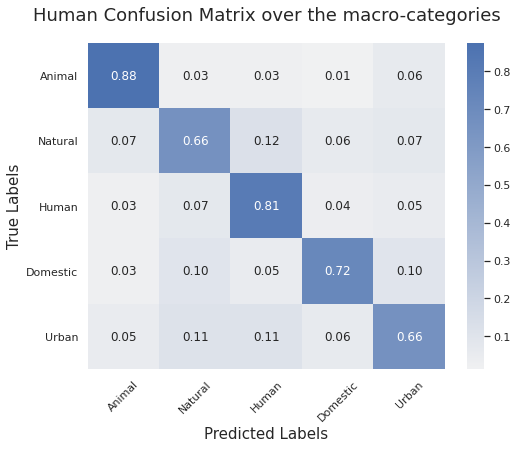

In [20]:
macro_categories = ['Animal', 'Natural', 'Human', 'Domestic', 'Urban']
macro_CNN_confmat = Normalize_Confusion_Matrix(nb1.compute_macro_conf_mat(CNN_confmat))

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.heatmap(macro_CNN_confmat, cmap=sns.color_palette("light:b", as_cmap=True), annot=True, fmt='.2f', ax=ax)
ax.set_title('Human Confusion Matrix over the macro-categories', fontsize=18, y=1.05)
ax.set_xticklabels(macro_categories, rotation=45)
ax.set_yticklabels(macro_categories, rotation=0)

ax.set_xlabel('Predicted Labels', fontsize=15)
ax.set_ylabel('True Labels', fontsize=15);

Let's now give a look at the differences among different classification approaches. In the following plots, we will represent which categories are better predicted by one method respect to the other: .-----------------

In [39]:
# Construct a proper colomap to distinguish macro-categories
animals  = [5, 13, 16, 18, 25, 29, 30, 34, 37, 39]
natural  = [7, 14, 15, 35, 36, 38, 43, 44, 48, 49]
humans   = [1, 2,   9, 12, 17, 21, 24, 32, 41, 42]
domestic = [3, 10, 11, 19, 20, 26, 31, 33, 46, 47]
urban    = [0, 4,   6,  8, 22, 23, 27, 28, 40, 45]
  
colors = ['firebrick', 'green', 'gold', 'blueviolet', 'navy']
macro  = ['animals', 'natural', 'humans', 'domestic', 'urban']

colormap = np.empty(50, dtype='U10')
for (col, idx) in zip(colors, [animals, natural, humans, domestic, urban]):
    colormap[idx] = col

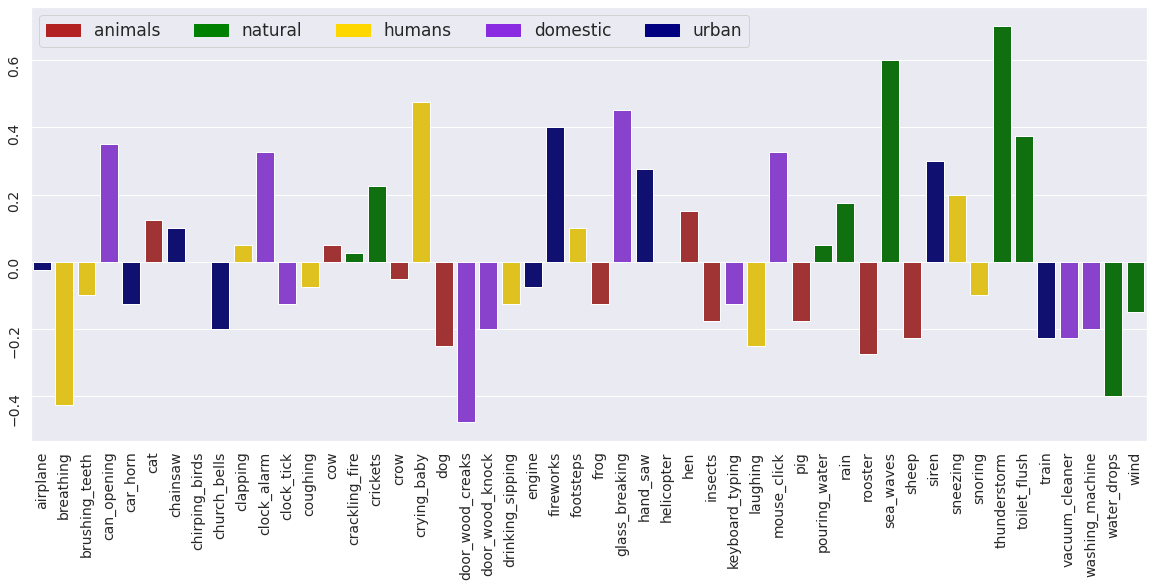

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.barplot(x=np.unique(list(nb1.get_label_map().values())), 
            y=[feat_confmat[idx][idx] - CNN_confmat[idx][idx] for idx in range(50)], palette=colormap)

ax.legend(handles=[mpatches.Patch(color=c, label=l) for c, l in zip(colors, macro)], fontsize=17, ncol=5)

ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='both', labelrotation=90, labelsize=14)

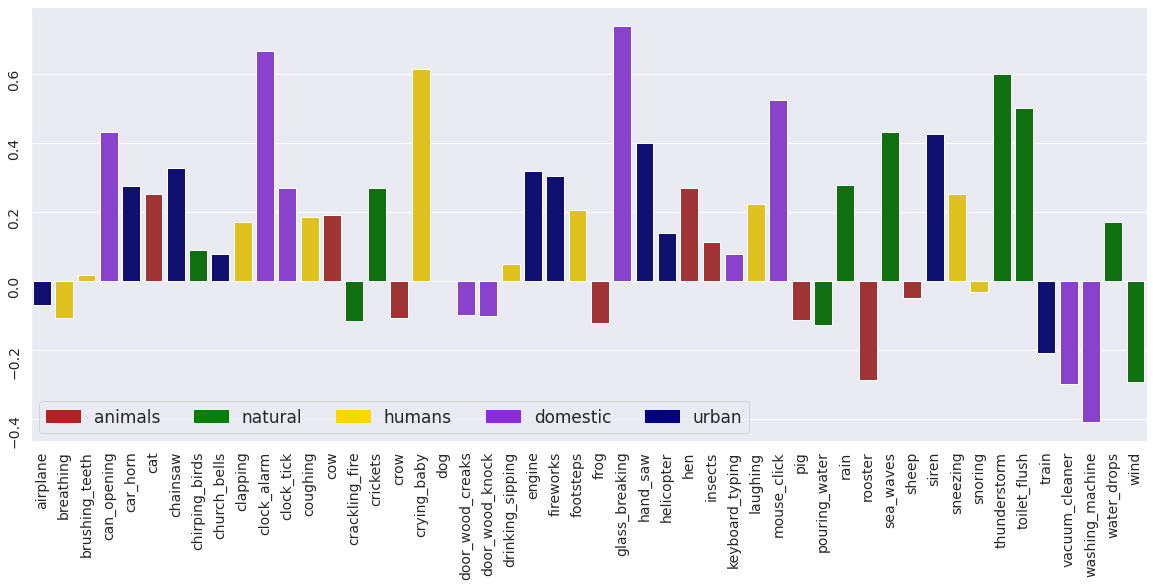

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

sns.barplot(x=np.unique(list(nb1.get_label_map().values())), 
            y=[human_confmat[idx][idx] - CNN_confmat[idx][idx] for idx in range(50)], palette=colormap)

ax.legend(handles=[mpatches.Patch(color=c, label=l) for c, l in zip(colors, macro)], fontsize=17, ncol=5)

ax.tick_params(axis='x', labelrotation=90)
ax.tick_params(axis='both', labelrotation=90, labelsize=14)

Comment

### with data augmentation

In [ ]:
ICC_aug_spectrograms = ImageClipsClassifier(Initialize_CNN(), batch_size=80, epochs=100, verbose=1)
aug_spectrograms_scores = ICC_aug_spectrograms.TrainTest_Model(
    tfrecord = os.getcwd() + '/augmented_tfrecords/augmented_data_train_spectrograms.tfrecords', 
    val_set  = os.getcwd() +  '/augmented_tfrecords/augmented_data_test_spectrograms.tfrecords')

## FFN + CNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tarfile
tar = tarfile.open('/content/drive/MyDrive/machine_learning_data/img_feat_lab_spectrograms.tar.xz', "r:xz")
tar.extractall()
tar.close()

In [ ]:
def Read_TFRecord(example, img_shape=(300, 600, 4), feat_len=110, n_classes=50):
    """Parse the input tf.train.Example proto using a proper dictionary."""
    
    # Create a dictionary describing the features.
    tfrecord_format = { 'image'    : tf.io.FixedLenFeature([], tf.string),
                        'features' : tf.io.FixedLenFeature([feat_len], tf.float32),
                        'label'    : tf.io.FixedLenFeature([], tf.int64) }
    
    example = tf.io.parse_single_example(example, tfrecord_format)
    
    # Decode the image
    image = tf.io.decode_raw(example['image'], out_type=tf.uint8)
    image = tf.reshape(image, shape=img_shape)

    # Load the vector of features
    features = tf.reshape(example['features'], shape=(feat_len,))

    # Read the label
    label = tf.cast(tf.one_hot(example['label'], depth=n_classes), tf.uint8)
    
    return ({'Spectrogram':image, 'Features vector':features}, {'Predictions':label})

In [ ]:
def Load_data(path, batch_size=16, test_frac=0.2, img_shape=(300, 600, 4), feat_len=110, n_classes=50):

    # Load the dataset
    ds = tf.data.TFRecordDataset(path, num_parallel_reads=tf.data.AUTOTUNE)
    ds.cache()

    # Shuffle the dataset
    full_len = ds.reduce(np.int64(0), lambda x, _: x + 1).numpy()
    ds = ds.shuffle(full_len, reshuffle_each_iteration=False)
    # If the order is ininfluent, this will speed up the computation
    opt = tf.data.Options()
    opt.experimental_deterministic = False
    ds = ds.with_options(opt)

    # Split the dataset in train and validation sets
    train_size = int(full_len*(1-test_frac))
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size)

    # Read and convert the data stored
    train_ds = train_ds.map(lambda x: Read_TFRecord(x, img_shape, feat_len, n_classes))
    val_ds   =   val_ds.map(lambda x: Read_TFRecord(x, img_shape, feat_len, n_classes))

    # Batch and prefetch
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    val_ds   =   val_ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds

In [ ]:
train_ds, val_ds = Load_data('img_feat_lab_spectrograms.tfrecords')

In [ ]:
def Tune_Normalizer(train_ds):
    """Given a trainin Dataset, this function extract the sub-dataset corresponding to 
    the features vectors and apply the function 'adapt' for the normalization layer."""
    
    feat_ds = train_ds.map(lambda x, lab: x['Features vector'])
    
    # Create a Normalization layer and set its internal state using the training data
    normalizer = tf.keras.layers.experimental.preprocessing.Normalization(name='Normalizer')
    normalizer.adapt(feat_ds)
    
    return normalizer

normalizer = Tune_Normalizer(train_ds)

In [ ]:
import shutil
shutil.rmtree(os.getcwd()+'/logs/')

In [ ]:
def FFN_CNN(feat_normalizer):
    
    feat_input = tf.keras.Input(shape=(110,), name='Features vector')
    x1 = feat_normalizer(feat_input)

    x1 = layers.Dense(1024, name='block1_fc')(x1)
    x1 = layers.PReLU(name='block1_act')(x1)
    x1 = layers.Dropout(0.5, name='block1_dropout')(x1)
    x1 = layers.BatchNormalization(name='block1_batchnorm')(x1)
    
    x1 = layers.Dense(512, name='block2_fc')(x1)
    x1 = layers.PReLU(name='block2_act')(x1)
    x1 = layers.Dropout(0.5, name='block2_dropout')(x1)
    x1 = layers.BatchNormalization(name='block2_batchnorm')(x1)

    

    img_input  = tf.keras.Input(shape=(300, 600, 4), name='Spectrogram')
    x2 = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1, name='Rescaling')(img_input)

    x2 = layers.Conv2D(filters=64, kernel_size=11, strides=4, padding='same', name='block1_conv1')(x2)
    x2 = layers.PReLU(name='block1_act1')(x2)
    x2 = layers.MaxPool2D(3, strides=(2,4), name='block1_pool')(x2)

    x2 = layers.Conv2D(filters=128, kernel_size=5, padding='same', name='block2_conv1')(x2)
    x2 = layers.PReLU(name='block2_act1')(x2)
    x2 = layers.MaxPool2D(3, strides=2, name='block2_pool')(x2)
    
    x2 = layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv1')(x2)
    x2 = layers.PReLU(name='block3_act1')(x2)
    x2 =  layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv2')(x2)
    x2 = layers.PReLU(name='block3_act2')(x2)
    x2 = layers.Conv2D(filters=256, kernel_size=3, padding='same', name='block3_conv3')(x2)
    x2 = layers.PReLU(name='block3_act3')(x2)
    x2 = layers.MaxPool2D(3, strides=2, name='block3_pool')(x2)

    x2 = layers.Dropout(0.5, name='block4_dropout1')(x2)
    x2 = layers.Flatten(name='block4_flatten')(x2)
    x2 = layers.Dense(256, name='block4_fc1')(x2)
    x2 = layers.PReLU(name='block4_act1')(x2)
    x2 = layers.Dropout(0.5, name='block4_dropout2')(x2)
    x2 = layers.Dense(256, name='block4_fc2')(x2)
    x2 = layers.PReLU(name='block4_act2')(x2)
    x2 = layers.Dropout(0.5, name='block4_dropout3')(x2)


    x = layers.concatenate([x1, x2])
    predictions = layers.Dense(50, name='Predictions')(x)

    return tf.keras.Model(inputs=[feat_input, img_input], outputs=[predictions])

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [ ]:
tf.keras.utils.plot_model(FFN_CNN(normalizer), "test_model.png", show_shapes=True)


In [ ]:
FFN_CNN(normalizer).summary()

In [ ]:
# Define the learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

In [ ]:
model = FFN_CNN(normalizer)
optimizer=tf.keras.optimizers.Adamax(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
opt = tf.keras.optimizers.SGD(0.0005)
model.compile(opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
model.fit(train_ds, epochs=100, verbose=0, callbacks=[TqdmCallback(verbose=1), tensorboard_callback], validation_data=val_ds)

In [ ]:
%tensorboard --logdir logs/fit

<div class="cite2c-biblio"></div>